# Plant Seedling Classification

## Importing libraries

In [1]:
import os 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math 
import cv2

# Tensorflow Modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

2023-10-20 12:10:56.715986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images = np.load('images.npy')
labels = pd.read_csv('labels.csv')

In [3]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Plot images from each of the class

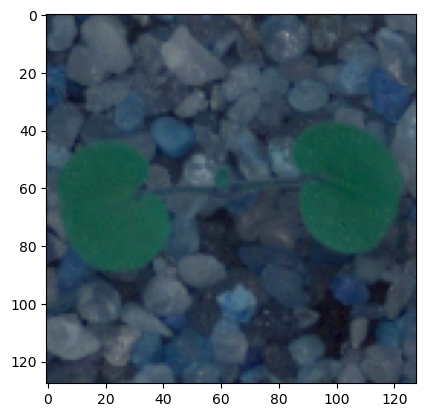

In [4]:
imgplot = plt.imshow(images[0])

This is a picture of the first image stored in the images dataset.

Lets make a code to visualize random images in each class

In [5]:
def plot_images(images, labels):
    num_classes = 10
    categories = np.unique(labels)
    keys = dict(labels['Label'])
    rows = 3
    cols = 4
    fig = plt.figure(figsize = (10,8))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels)) 
            ax = fig.add_subplot(rows,cols, i * rows + j + 1)
            ax.imshow(images[random_index,:])
            ax.set_title(keys[random_index])
            
    plt.show()
    

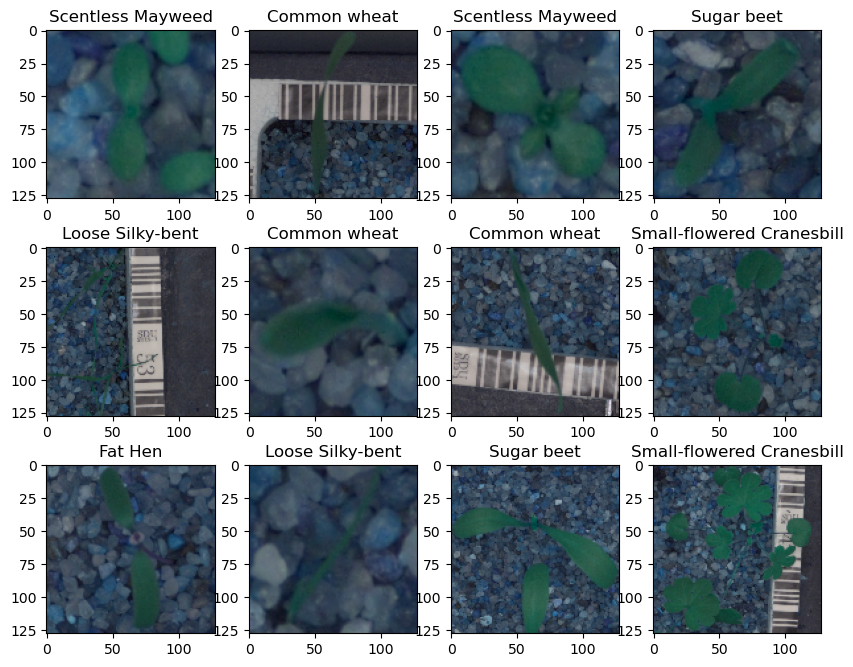

In [6]:
plot_images(images, labels)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

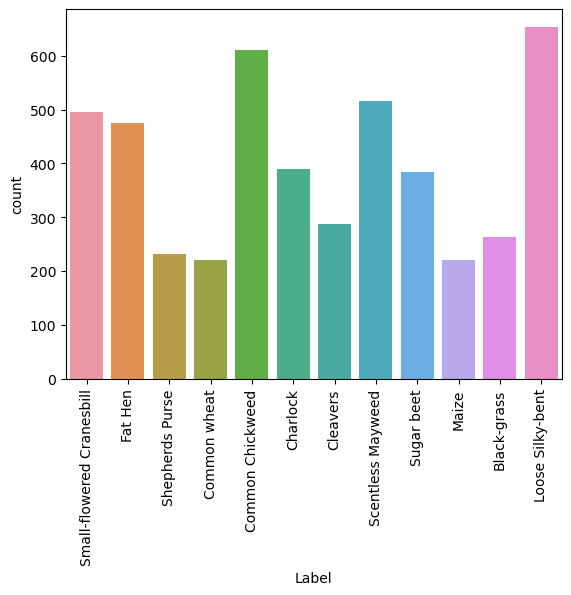

In [7]:
sns.countplot(data = labels, x = 'Label')
plt.xticks(rotation = 'vertical')

The data set has some classes having more images than others. During training this is going to be an issue because the model will be better trained for specfic classes than others. Meaning, itll be better at identifying petals of a specific type than identifying petals of other types.

Thus we will use data augmentation techniques to supply more trainable data as well as using confusion matrices and precision and recall to evaluate the model. 

## Data Preprocessing 

In [8]:
# Converting images from BGR to RGB using cvtColor function of OpenCV

for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

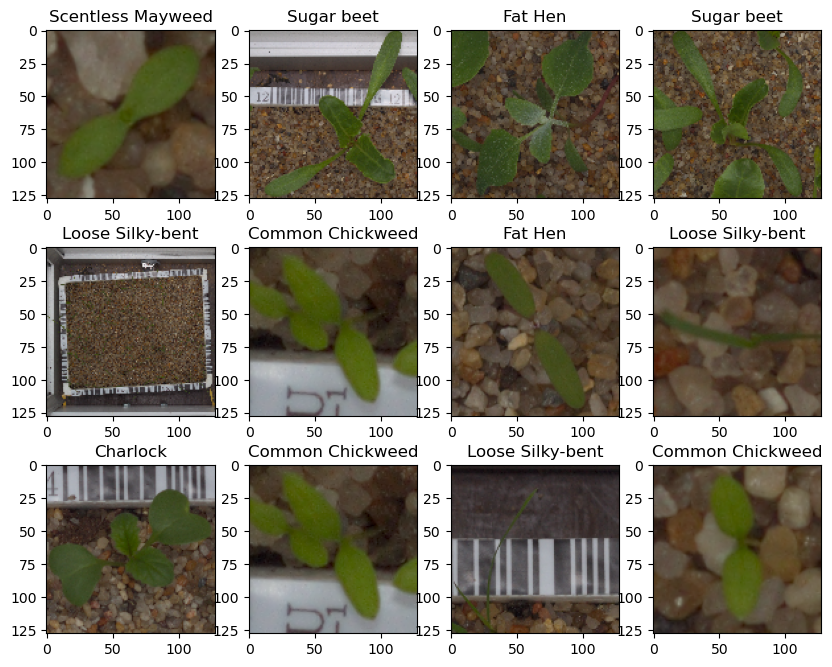

In [9]:
plot_images(images, labels)

### Resizing Images

In [10]:
images_smaller = []
for i in range(len(images)):
    images_smaller.append(cv2.resize(images[i], (64,64), interpolation = cv2.INTER_LINEAR)) #changes the size to a 64 x 64 pixel image

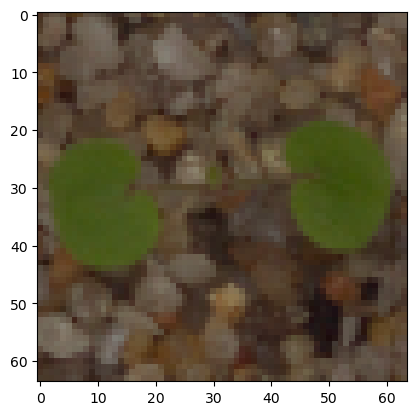

In [11]:
plt.imshow(images_smaller[0])

This an image from the smaller images dataset which was made by resizing the image from 128 pixels to 64 pixels. This is image is shown just to test and see if the new dataset was properly created

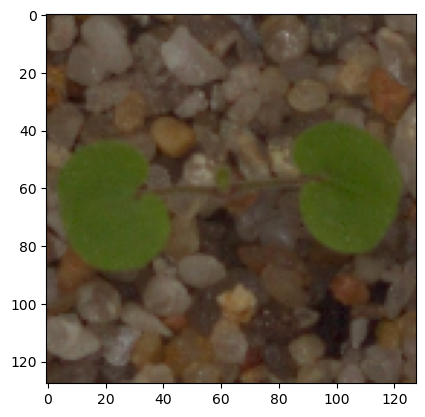

In [12]:
plt.imshow(images[0])

The above picture is the first image before it was resized just to make sure the resizing looks legitimate.

## Data Prep for Modeling

In [13]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_smaller), labels, test_size = 0.1, random_state = 42, stratify = labels) # takes your x and y data so the images and labels
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.1, random_state = 42, stratify = y_temp)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


# Encoding target variables

In [14]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded = enc.fit_transform(y_test)
y_val_encoded = enc.fit_transform(y_val)

In [15]:
pd.DataFrame(y_train_encoded)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3842,0,0,0,0,0,0,0,1,0,0,0,0
3843,1,0,0,0,0,0,0,0,0,0,0,0
3844,0,0,0,1,0,0,0,0,0,0,0,0
3845,0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
y_train

,Label
1032,Shepherds Purse
3199,Scentless Mayweed
428,Small-flowered Cranesbill
3019,Scentless Mayweed
4081,Black-grass
...,...
3673,Maize
4056,Black-grass
1684,Common Chickweed
1205,Common wheat


In [17]:
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((3847, 12), (475, 12), (428, 12))

How to check which columns is which class?

## Data Normalization

In [18]:
X_train_normalized = X_train.astype('float32')/255.0 #divides all values in the x data by 255. 
X_val_normalized = X_val.astype('float32')/255.0     #Scaling the data down by 255
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [19]:
from tensorflow.keras import backend

In [20]:
# Clear Backend, wipe yo booty
backend.clear_session()

In [21]:
import random 
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Lets build a CNN model
The 2 main parts are:
1. The feature extraction layers, which are compromised of convulution and pooling layers
2. The fully connected classification layers for prediction

In [22]:
from tensorflow.keras.models import Sequential

In [23]:
model1 = Sequential()

# add first conv layer with 64 filters and kernel size 3x3, padding = 'same' provudes the output size same as input size
# input shape is the dimensions of images
model1.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same', input_shape = (64,64,3)))

# adding max pooling to reduce size of output of first conv layer
model1.add(MaxPooling2D((2,2), padding = 'same'))

# Creating 2 similar conv and max pooling layers
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D((2,2), padding = 'same'))

model1.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D((2,2), padding = 'same'))

model1.add(Flatten()) # flattening the output of the conv layer after max pooling to make it ready for creating connections

# Add fully connected dense layer with 100 neurons and add dropout
model1.add(Dense(100, activation = 'relu'))
model1.add(Dropout(0.3))

# Add output layer
model1.add(Dense(12, activation = 'softmax'))

# Use Adam optimizer
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['Accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

## Fitting Model on training data

In [25]:
# The model was initially at 30 epochs but after training, it seems best to train till 11 epochs
history = model1.fit(X_train_normalized, y_train_encoded, epochs = 11, validation_data = (X_val_normalized, y_val_encoded), batch_size = 32, verbose = 2)

Epoch 1/11
121/121 - 37s - loss: 1.2164 - Accuracy: 0.5763 - val_loss: 1.0681 - val_Accuracy: 0.6589 - 37s/epoch - 310ms/step
Epoch 2/11
121/121 - 38s - loss: 1.0654 - Accuracy: 0.6283 - val_loss: 0.9941 - val_Accuracy: 0.6752 - 38s/epoch - 315ms/step
Epoch 3/11
121/121 - 38s - loss: 0.9226 - Accuracy: 0.6772 - val_loss: 0.8952 - val_Accuracy: 0.7033 - 38s/epoch - 317ms/step
Epoch 4/11
121/121 - 38s - loss: 0.8430 - Accuracy: 0.7104 - val_loss: 0.8755 - val_Accuracy: 0.6963 - 38s/epoch - 316ms/step
Epoch 5/11
121/121 - 40s - loss: 0.7611 - Accuracy: 0.7375 - val_loss: 0.9085 - val_Accuracy: 0.6939 - 40s/epoch - 331ms/step
Epoch 6/11
121/121 - 41s - loss: 0.7260 - Accuracy: 0.7499 - val_loss: 0.7631 - val_Accuracy: 0.7500 - 41s/epoch - 339ms/step
Epoch 7/11
121/121 - 40s - loss: 0.6580 - Accuracy: 0.7687 - val_loss: 0.7506 - val_Accuracy: 0.7593 - 40s/epoch - 333ms/step
Epoch 8/11
121/121 - 40s - loss: 0.6137 - Accuracy: 0.7907 - val_loss: 0.7096 - val_Accuracy: 0.7780 - 40s/epoch - 326

In [26]:
hist_m1 = pd.DataFrame(history.history)
hist_m1

,loss,Accuracy,val_loss,val_Accuracy
0,1.216430,0.576293,1.068070,0.658879
1,1.065353,0.628282,0.994066,0.675234
2,0.922587,0.677151,0.895182,0.703271
3,0.843032,0.710424,0.875516,0.696262
4,0.761063,0.737458,0.908468,0.693925
5,0.725984,0.749935,0.763063,0.750000
6,0.657963,0.768651,0.750580,0.759346
7,0.613657,0.790746,0.709574,0.778037
8,0.558717,0.800624,0.742915,0.773364
9,0.536962,0.809462,0.686034,0.771028


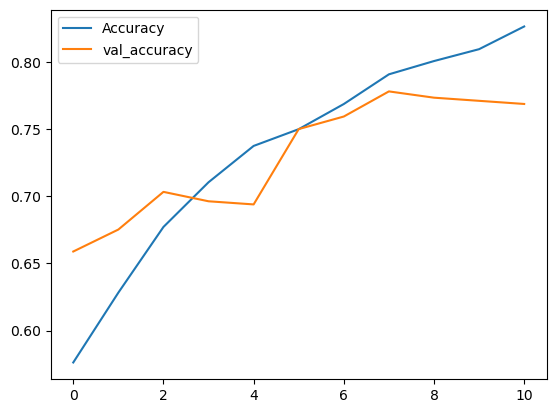

In [27]:
plt.plot(hist_m1['Accuracy'])
plt.plot(hist_m1['val_Accuracy'])
plt.legend(['Accuracy','val_accuracy'])

In [28]:
model1_acc_diff = hist_m1['Accuracy'] - hist_m1['val_Accuracy']
model1_acc_diff

0    -0.082585
1    -0.046952
2    -0.026120
3     0.014162
4     0.043532
5    -0.000065
6     0.009305
7     0.012709
8     0.027259
9     0.038434
10    0.057667
dtype: float64

Model1's validation accuracy seems to fluctuate and deviate further from the training accuracy indicating that there is some instability in the model. This model should be trained for about 11 epochs as that is the minimum difference between accuracy and val_accuracy. At 11 epochs, the validation accuracy is 77.8% and the training accuracy is 79.2%

In [29]:
accuaracy_m1 = model1.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

15/15 - 1s - loss: 0.7366 - Accuracy: 0.7663 - 1s/epoch - 81ms/step


In [30]:
y_pred_m1 = model1.predict(X_test_normalized)

15/15 [==============================] - 1s 77ms/step


In [31]:
pd.DataFrame(y_pred_m1)

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.886871e-17,6.784645e-15,1.665330e-19,9.999967e-01,4.542325e-09,1.058159e-08,3.463332e-13,1.738628e-06,1.350277e-06,7.029245e-08,5.164735e-15,5.568356e-09
1,1.280964e-12,7.981682e-04,2.841257e-07,3.107192e-09,2.126072e-15,4.045893e-07,9.255181e-11,3.174451e-06,1.240112e-09,8.264247e-05,9.991152e-01,3.667627e-08
2,5.248666e-09,2.209692e-05,1.023978e-08,1.572386e-06,2.176761e-12,1.607282e-04,6.867083e-07,1.208044e-04,6.440641e-10,6.271814e-04,9.990091e-01,5.778094e-05
3,7.891881e-14,1.224240e-10,1.412006e-17,2.792047e-08,1.426231e-20,3.783421e-09,7.239905e-12,3.332419e-07,6.021484e-15,3.425945e-06,9.999961e-01,1.478563e-09
4,7.245414e-11,9.835269e-01,1.063740e-02,8.470718e-10,1.018357e-09,2.270505e-04,6.744869e-11,3.315542e-07,9.903540e-06,6.220894e-05,5.421917e-03,1.141537e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
470,2.646549e-03,6.445953e-06,3.984563e-08,8.598918e-01,6.683098e-06,1.574796e-02,1.751958e-03,2.158197e-02,1.092758e-03,1.785973e-04,4.547308e-02,5.162207e-02
471,1.966052e-06,4.452195e-03,9.928266e-01,5.276400e-10,1.974864e-05,2.123615e-03,2.110091e-07,4.973263e-06,1.908860e-04,5.821547e-06,3.269724e-04,4.706735e-05
472,2.644191e-01,4.269973e-08,3.767898e-05,3.470583e-08,1.914634e-01,1.377496e-03,5.422453e-01,3.295417e-07,4.559705e-04,1.189615e-07,3.227089e-07,2.330767e-07
473,8.672248e-07,1.240742e-04,2.044218e-04,1.230784e-02,1.761883e-04,4.896389e-04,1.382282e-05,3.882350e-04,9.513464e-01,3.387203e-02,7.802035e-07,1.075645e-03


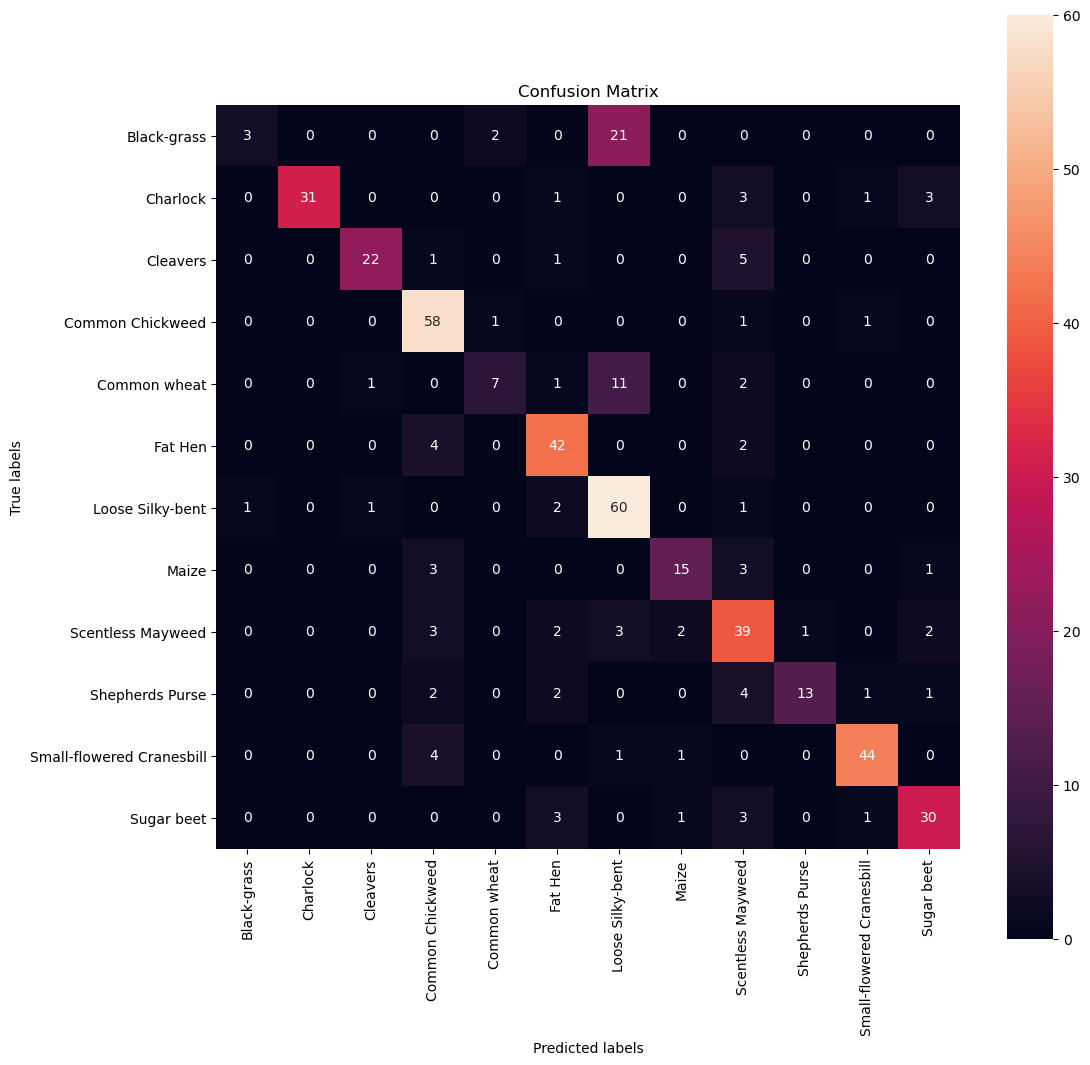

In [33]:
y_pred_arg = np.argmax(y_pred_m1, axis = 1) # goes through each probability in an array and selects the class with highest prob and makes it 1 and everything else 0
y_test_arg = np.argmax(y_test_encoded, axis = 1) # pretty much finding the highest probability and choosing that as the predicted class

confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg) 
# tf.math.confusion_matrix(y_axis_arg, x_axsi_arg) or (y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (12,12))

sns.heatmap(confusion_matrix, 
           annot = True,
           fmt = 'd',
           square = True,
           ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()

In [34]:
from sklearn.metrics import classification_report

In [36]:
y_pred_m1

array([[3.88687107e-17, 6.78464455e-15, 1.66533042e-19, ...,
        7.02924510e-08, 5.16473512e-15, 5.56835644e-09],
       [1.28096448e-12, 7.98168185e-04, 2.84125747e-07, ...,
        8.26424730e-05, 9.99115229e-01, 3.66762727e-08],
       [5.24866595e-09, 2.20969196e-05, 1.02397815e-08, ...,
        6.27181376e-04, 9.99009073e-01, 5.77809406e-05],
       ...,
       [2.64419138e-01, 4.26997282e-08, 3.76789831e-05, ...,
        1.18961523e-07, 3.22708900e-07, 2.33076676e-07],
       [8.67224799e-07, 1.24074228e-04, 2.04421827e-04, ...,
        3.38720270e-02, 7.80203493e-07, 1.07564486e-03],
       [2.11977977e-10, 2.88574462e-08, 1.61229190e-11, ...,
        8.35414290e-01, 2.43925260e-05, 3.21762013e-06]], dtype=float32)

In [37]:
y_test_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [38]:
cr_m1 = classification_report(y_test_arg, y_pred_arg)
print(cr_m1)

              precision    recall  f1-score   support

           0       0.75      0.12      0.20        26
           1       1.00      0.79      0.89        39
           2       0.92      0.76      0.83        29
           3       0.77      0.95      0.85        61
           4       0.70      0.32      0.44        22
           5       0.78      0.88      0.82        48
           6       0.62      0.92      0.75        65
           7       0.79      0.68      0.73        22
           8       0.62      0.75      0.68        52
           9       0.93      0.57      0.70        23
          10       0.92      0.88      0.90        50
          11       0.81      0.79      0.80        38

    accuracy                           0.77       475
   macro avg       0.80      0.70      0.72       475
weighted avg       0.79      0.77      0.75       475



In [39]:
del model1
del history

## Model Refinement

This time we're going to make the model better by applying data augmentation on to our training data.

Reduction Learning Rate:

ReduceLRonPlateau() is a funciton that will be used to decreas learning rate by some actor if loss isn't decreasing for some time. 

In [40]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)


In [41]:
# clearing backend
backend.clear_session()

In [42]:
import random 
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [43]:
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )

In [44]:
# Initialize model

model2 = Sequential()

# Add first conv layer
model2.add(Conv2D(128,(3,3), padding = 'same', activation = 'relu', input_shape = (64,64,3)))
# Add max pooling to reduce size of ouput of first conv layer
model2.add(MaxPooling2D((2,2), padding = 'same'))
model2.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D((2,2), padding = 'same'))
model2.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D((2,2), padding = 'same'))
# model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(100, activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(12, activation = 'softmax'))

model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
epochs = 30
batch_size = 64

history_2 = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded, batch_size = batch_size, shuffle = False), epochs = epochs, steps_per_epoch = X_train_normalized.shape[0] // batch_size, validation_data = (X_val_normalized, y_val_encoded), verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 44s 715ms/step - loss: 2.4380 - accuracy: 0.1393 - val_loss: 2.3624 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 42s 704ms/step - loss: 2.1265 - accuracy: 0.2873 - val_loss: 1.8322 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 45s 742ms/step - loss: 1.7438 - accuracy: 0.3894 - val_loss: 1.5878 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 44s 751ms/step - loss: 1.6020 - accuracy: 0.4335 - val_loss: 1.3927 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 45s 750ms/step - loss: 1.4298 - accuracy: 0.4898 - val_loss: 1.2616 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 42s 703ms/step - loss: 1.3117 - accuracy: 0.5358 - val_loss: 1.1037 - val_accuracy: 0.6121 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 45s 751ms/st

In [47]:
hist2 = pd.DataFrame(history_2.history)
hist2

,loss,accuracy,val_loss,val_accuracy,lr
0,2.438049,0.139307,2.362350,0.242991,0.00100
1,2.126472,0.287338,1.832201,0.366822,0.00100
2,1.743791,0.389374,1.587754,0.453271,0.00100
3,1.602024,0.433518,1.392747,0.516355,0.00100
4,1.429751,0.489823,1.261587,0.553738,0.00100
5,1.311716,0.535818,1.103704,0.612150,0.00100
6,1.175619,0.587365,1.063387,0.649533,0.00100
7,1.108523,0.615385,0.949701,0.679907,0.00100
8,1.054650,0.625430,0.911912,0.698598,0.00100
9,0.990294,0.660851,1.010462,0.626168,0.00100


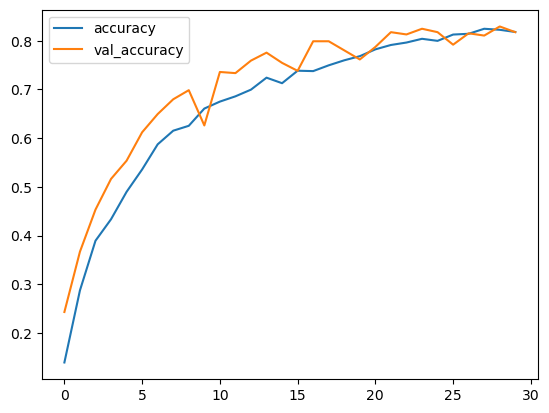

In [48]:
plt.plot(hist2['accuracy'])
plt.plot(hist2['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

In [49]:
acc_diff_m2 = hist2.accuracy - hist2.val_accuracy

In [50]:
acc_diff_m2

0    -0.103683
1    -0.079484
2    -0.063898
3    -0.082837
4    -0.063915
5    -0.076331
6    -0.062168
7    -0.064522
8    -0.073169
9     0.034683
10   -0.060856
11   -0.047681
12   -0.059637
13   -0.051408
14   -0.041747
15    0.000250
16   -0.061291
17   -0.049396
18   -0.020395
19    0.006755
20   -0.004935
21   -0.026322
22   -0.016626
23   -0.020643
24   -0.017863
25    0.020791
26   -0.000988
27    0.013995
28   -0.006812
29    0.000377
dtype: float64

The model should be trained for 7 epochs

In [51]:
hist2.accuracy[10]

0.6751255393028259

In [52]:
# evaluating accuracy of model on testing data
accuracy_m2 = model2.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

15/15 - 1s - loss: 0.6706 - accuracy: 0.8126 - 1s/epoch - 87ms/step


In [53]:
y_pred_m2 = model2.predict(X_test_normalized)

15/15 [==============================] - 1s 93ms/step


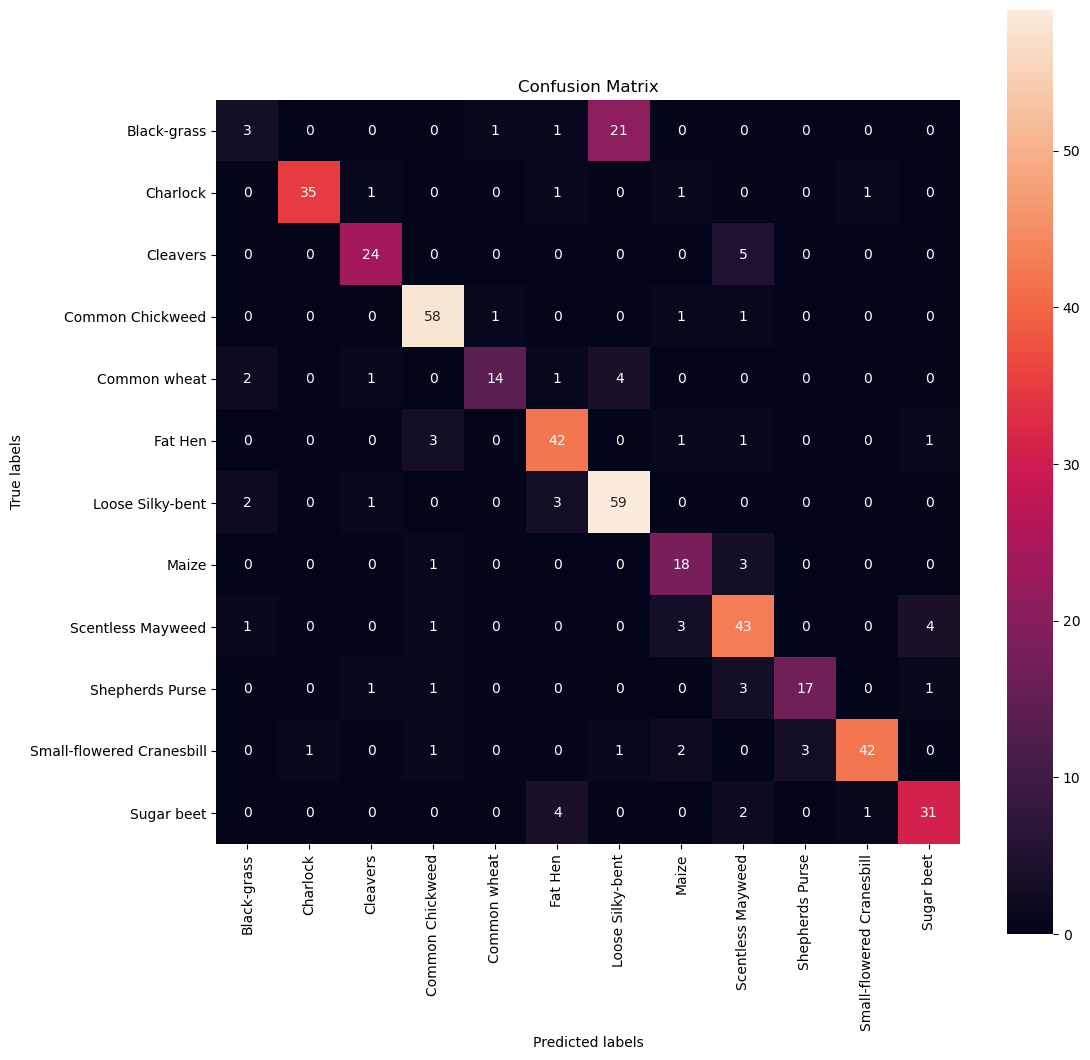

In [54]:
y_pred_arg = np.argmax(y_pred_m2, axis = 1) # goes through each probability in an array and selects the class with highest prob and makes it 1 and everything else 0
y_test_arg = np.argmax(y_test_encoded, axis = 1) # pretty much finding the highest probability and choosing that as the predicted class

confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg) 
# tf.math.confusion_matrix(y_axis_arg, x_axsi_arg) or (y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (12,12))

sns.heatmap(confusion_matrix, 
           annot = True,
           fmt = 'd',
           square = True,
           ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()

In [55]:
cr_m2 = classification_report(y_test_arg, y_pred_arg)
print(cr_m2)

              precision    recall  f1-score   support

           0       0.38      0.12      0.18        26
           1       0.97      0.90      0.93        39
           2       0.86      0.83      0.84        29
           3       0.89      0.95      0.92        61
           4       0.88      0.64      0.74        22
           5       0.81      0.88      0.84        48
           6       0.69      0.91      0.79        65
           7       0.69      0.82      0.75        22
           8       0.74      0.83      0.78        52
           9       0.85      0.74      0.79        23
          10       0.95      0.84      0.89        50
          11       0.84      0.82      0.83        38

    accuracy                           0.81       475
   macro avg       0.80      0.77      0.77       475
weighted avg       0.81      0.81      0.80       475

